# **Sentiment Analysis of Twitter Text Data in Python**

### This is the Python notebook for sentiment analysis in Python. The following techniques will be utilized:

1. **VADER (Valence Aware Dictionary and Sentiment Reasoner) Model** : Bag of Words Approach 
2. **RoBERTa (Robustly Optimized Bidirectional Encoder Representations from Transformers) Model** : Contextualized Embeddings Approach

# **Step 1: Read Data and Data Preprocessing**

Import libraries for the following: 
- Data Manipulation 
- Data Visualization 
- Natural Language Processing (NLP) 
- Exploratory Data Analysis (EDA)

In [1]:
# Data manipulation and analysis
import pandas as pd    # For handling data in DataFrames, for data manipulation, cleaning, and analysis.
import numpy as np     # For numerical operation, arrays, and advanced math functions.

# Visualization libraries
import matplotlib.pyplot as plt    # For creating static, animated, and interactive visualizations.
import seaborn as sns              # High-level interface for creating attractive and informative statistical graphs.

# EDA (Exploratory Data Analysis) modules
import nltk                             # Natural Language Toolkit, for working with human language data (text).
from nltk.corpus import stopwords       # For importing stopwords ('the', 'is') to exclude in text analysis.
from collections import Counter         # For counting frequency of elements in list.
from nltk.tokenize import word_tokenize # For splitting text into individual words (tokens). 
from nltk import pos_tag                # For parts of speech (POS) tagging in tokenized text, For linguistic analysis.
import re                               # Regular expressions for pattern matching, useful for cleaning or extracting text.

# Plotting style
plt.style.use('ggplot')     # Sets particular plotting style, for polished plots.

Load the dataset from a CSV file into a DataFrame

In [2]:
df_dataset = pd.read_csv('text_modified.csv') 
print(df_dataset.shape)

(416809, 3)


### Stratified Random Sampling
Check label values and distribution

In [3]:
print(df_dataset['label'].value_counts())

label
Joy         141067
Sadness     121187
Anger        57317
Fear         47712
Love         34554
Surprise     14972
Name: count, dtype: int64


Obtain the target sample size per label based on the smallest label size

In [4]:
min_count = df_dataset['label'].value_counts().min()
sample_size = 5000

Perform stratified random sampling with 42 as the seed for a reproducible dataset samples

In [5]:
df = df_dataset.groupby('label').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)

# Verify the result
print(df['label'].value_counts())

label
Anger       5000
Fear        5000
Joy         5000
Love        5000
Sadness     5000
Surprise    5000
Name: count, dtype: int64


/var/folders/5d/lv8_nvzx4_z5kndxtdyr5fph0000gn/T/ipykernel_11330/616092931.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_dataset.groupby('label').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)


Display first 5 rows of the dataset

In [6]:
df.head()

,Index,text,label
0,411553,i feel rebellious and i like it,Anger
1,18079,i feel completely agitated and full of blame,Anger
2,282107,i feel like a witch bc im aggravated and i wan...,Anger
3,49946,i feel really bitchy for doing this but im rea...,Anger
4,96367,i feel rude but i move past it immediately,Anger


## Data Cleaning

- This step is vital because it ensures that the dataset is free from noise, inconsistencies, and irrelevant information, making the data more accurate and reliable for analysis. For the code below, the preprocessing step helps remove unnecessary elements like stopwords, special characters, and numbers, allowing for more meaningful insights from the text data.

In [7]:
# Download stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

# Extend stopwords 
custom_stop_words = {
    "i", 
    "im", 
    "ive", 
    "dont", 
    "and", 
    "you", 
    "he", 
    "she", 
    "we", 
    "they", 
    "it", 
    "is", 
    "are", 
    "was", 
    "were", 
    "their", 
    "there"
}
stop_words.update(custom_stop_words) 

# Preprocess text (lowercase, remove stopwords, tokenize) 
def preprocess_text(text): 
    # Convert lowercase 
    text = text.lower()
    # Remove special characters and numbers 
    text = re.sub(r'\W+', ' ', text) 
    # Tokenize 
    words = text.split() 
    # Remove stopwords 
    words = [word for word in words if word not in stop_words] 
    return words 

# Apply preprocessing to dataset 
df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to /Users/zivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Index,text,label,processed_text
0,411553,i feel rebellious and i like it,Anger,"[feel, rebellious, like]"
1,18079,i feel completely agitated and full of blame,Anger,"[feel, completely, agitated, full, blame]"
2,282107,i feel like a witch bc im aggravated and i wan...,Anger,"[feel, like, witch, bc, aggravated, want, go, ..."
3,49946,i feel really bitchy for doing this but im rea...,Anger,"[feel, really, bitchy, really, iffy, read, jou..."
4,96367,i feel rude but i move past it immediately,Anger,"[feel, rude, move, past, immediately]"


# Exploratory Data Analysis

- This step is vital for text sentiment analysis because it helps to understand the underlying structure, patterns, and key features of the data. By performing EDA, we can identify trends, clean the data, and better prepare it for building accurate sentiment models, ensuring insights are derived from meaningful and relevant information.

Visualizing the distribution of each sentiment label in the sample data.

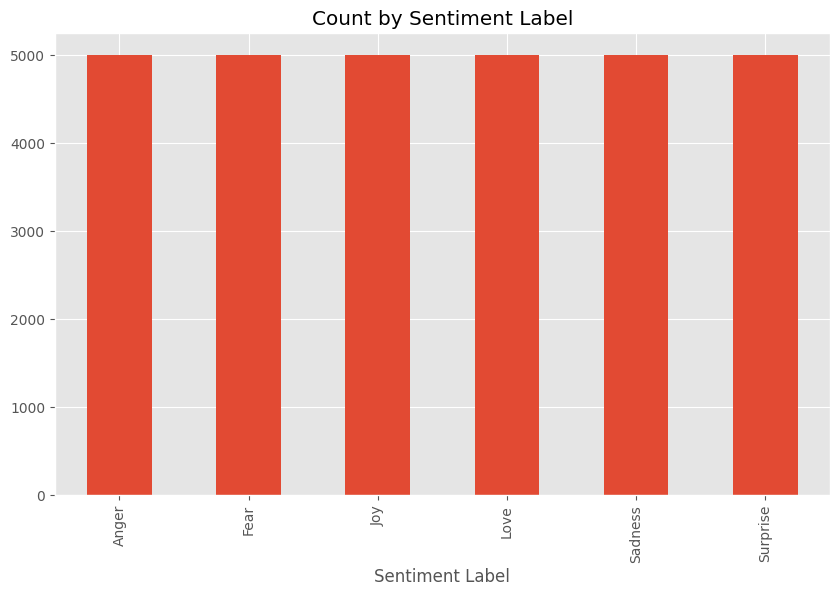

In [8]:
ax = df['label'].value_counts().sort_index().plot(
    kind = 'bar', 
    title = 'Count by Sentiment Label', 
    figsize = (10, 6)
) 
ax.set_xlabel('Sentiment Label') 
plt.show()

Display the specific counts of each sentiment label.

In [9]:
count = df['label'].value_counts()
count

label
Anger       5000
Fear        5000
Joy         5000
Love        5000
Sadness     5000
Surprise    5000
Name: count, dtype: int64

## Distribution of Emotions

### 1) Are certain emotions more prevalent than others in the dataset?

The emotions of Joy and Sadness are more prevalent with 346 and 304 instances respectively. These emotions are more dominant in contrast to Love with 76 instances, Anger with 135 instances, Fear with 109 instances, and Surprise with only 30 instances.
<br><br>

### 2) What is the frequency distribution of each emotion in the dataset?

The following are the number of tweets per emotions:
- **Sadness**: 304
- **Joy**: 346
- **Love**: 76
- **Anger**: 135
- **Fear**: 109
- **Surprise**: 30

### Data Normalization

- Data normalization is important because it helps balance the uneven distribution of senitment labels in the dataset. By ensuring that each emotion label is represented more equally, normalization prevents models from becoming biased towards the more frequent emotions. This results to more accurate and efficient analysis, as the model will better understand and predict all emotions rather than focusing on the majority class.

In [10]:
# Import resample method to tackle imbalance in dataset.
from sklearn.utils import resample 

# Check current distribution of sentiment labels in the dataset.
label_counts = df['label'].value_counts() 
print(label_counts)

label
Anger       5000
Fear        5000
Joy         5000
Love        5000
Sadness     5000
Surprise    5000
Name: count, dtype: int64


Plot normalized count of each sentiment label after upsampling

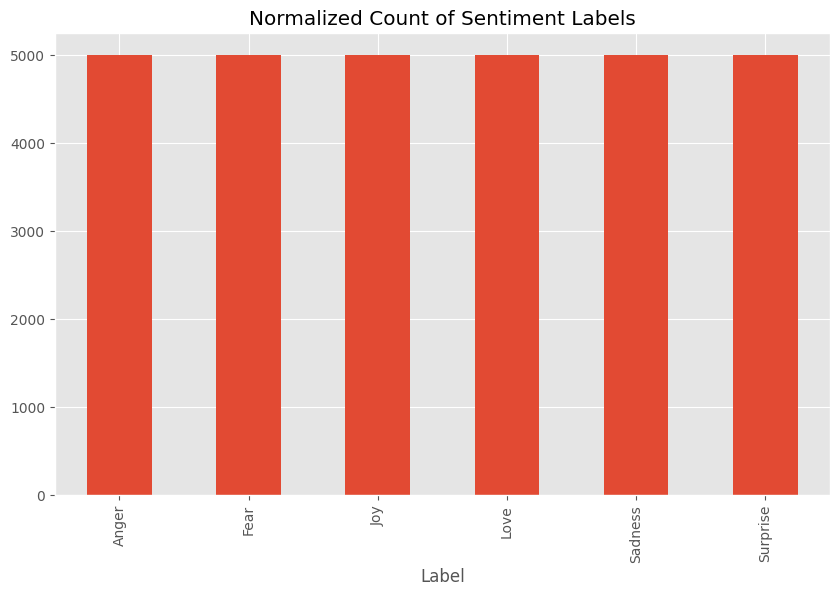

In [11]:
new_label_counts = df['label'].value_counts() 

ax = new_label_counts.plot(
    kind = 'bar', 
    title = 'Normalized Count of Sentiment Labels', 
    figsize = (10, 6)
) 

ax.set_xlabel('Label') 
plt.show()

In [12]:
df.head()

,Index,text,label,processed_text
0,411553,i feel rebellious and i like it,Anger,"[feel, rebellious, like]"
1,18079,i feel completely agitated and full of blame,Anger,"[feel, completely, agitated, full, blame]"
2,282107,i feel like a witch bc im aggravated and i wan...,Anger,"[feel, like, witch, bc, aggravated, want, go, ..."
3,49946,i feel really bitchy for doing this but im rea...,Anger,"[feel, really, bitchy, really, iffy, read, jou..."
4,96367,i feel rude but i move past it immediately,Anger,"[feel, rude, move, past, immediately]"


Calculate and add two new columns: character count and word count.

In [13]:
# Add column 'char_count' that calculates total number of characters in each tweet.
df['char_count'] = df['processed_text'].apply(lambda x: sum(len(word) for word in x))

# Add column 'word_count' that calculates total number of word in each tweet.
df['word_count'] = df['processed_text'].apply(len)

# Display first few rows with processed text, character count, and word count columns.
df[['processed_text', 'char_count', 'word_count']].head()

,processed_text,char_count,word_count
0,"[feel, rebellious, like]",18,3
1,"[feel, completely, agitated, full, blame]",31,5
2,"[feel, like, witch, bc, aggravated, want, go, ...",40,9
3,"[feel, really, bitchy, really, iffy, read, jou...",93,19
4,"[feel, rude, move, past, immediately]",27,5


Calculates average word count for each emotion label in the dataset.

In [14]:
# Group DataFrame by 'label' and calculate mean word count for each label.
avg_word_count_by_emotion = df.groupby('label')['word_count'].mean()
avg_word_count_by_emotion

label
Anger       8.9768
Fear        8.9740
Joy         9.3620
Love        9.8642
Sadness     8.8398
Surprise    9.4284
Name: word_count, dtype: float64

## Emotion by Word Count

### 3) What are the average word counts of the tweets of the different emotions?

The following are the average word counts of tweets per emotions:
- **Sadness**: 9.129944
- **Joy**: 8.306250
- **Love**: 9.664634
- **Anger**: 9.615854
- **Fear**: 9.259036
- **Surprise**: 9.443787


Categorize tweets into 'Short' or 'Long' based on the word count, and plots the distribution of emotions for each length.

In [15]:
# Add column 'message_length' that classifies each tweet as 'Short' or 'Long' based on whether word count is 10 or less.
df['message_length'] = df['word_count'].apply(lambda x: 'Short' if x <= 10 else 'Long') 

# Calculate distribution of emotions across tweet length categories (Short vs Long). 
# Group by message length and label, then calculate size of each group. 
# Unstack to create DataFrame with 'label' as columns.
length_emotion_distribution = df.groupby(['message_length', 'label']).size().unstack(fill_value = 0)

# Add 'Total' row and column to DataFrame to show total counts.
length_emotion_distribution.loc['Total'] = length_emotion_distribution.sum() 
length_emotion_distribution['Total'] = length_emotion_distribution.sum(axis = 1) 

# Display emotion distribution by tweet length.
length_emotion_distribution 

label,Anger,Fear,Joy,Love,Sadness,Surprise,Total
message_length,,,,,,,
Long,1578,1562,1702,1899,1548,1722,10011
Short,3422,3438,3298,3101,3452,3278,19989
Total,5000,5000,5000,5000,5000,5000,30000


Plot distribution of emotions across tweet length categories.

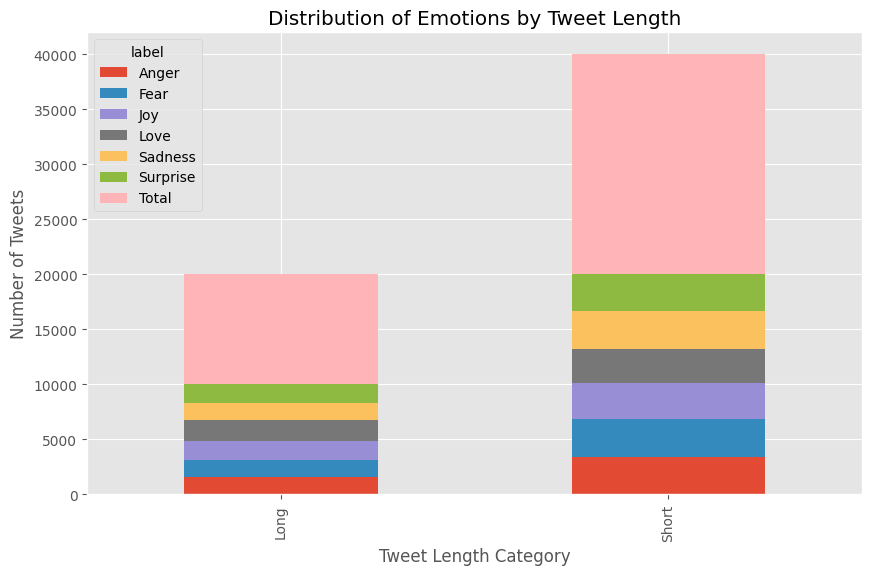

In [16]:
length_emotion_distribution.drop('Total').plot(
    kind = 'bar', 
    stacked = True, 
    figsize = (10, 6)
)
plt.title('Distribution of Emotions by Tweet Length')
plt.xlabel('Tweet Length Category')
plt.ylabel('Number of Tweets')
plt.show()

## Word Frequency

### 4) Are shorter or longer messages more likely to express certain emotions?

The table below shows the counts of emotions expressed in short and long messages:

| Length Category | Sadness | Joy   | Love | Anger | Fear | Surprise | **Total** |
|-----------------|---------|-------|------|-------|------|----------|-----------|
| **Long**        | 58    | 62  | 42 | 65  | 63 | 44      | **334** |
| **Short**       | 106    | 104 | 118 | 99  | 114 | 125     | **666** |
| **Total**       | **164** | **166** | **160** | **164** | **177** | **169** | **1000** |

Count common words for each emotion

In [17]:
common_words = {}
for label in df['label'].unique():
    # Get all processed words for the emotion
    words = df[df['label'] == label]['processed_text'].sum()  # Flatten the list of lists
    common_words[label] = Counter(words).most_common(10)  # Get the 10 most common words

# Display the most common words for each emotion
for emotion, words in common_words.items():
    print(f"Most common words for '{emotion}':")
    print(words)
    print()

Most common words for 'Anger':
[('feel', 3317), ('feeling', 1666), ('like', 874), ('really', 343), ('know', 303), ('get', 298), ('people', 275), ('little', 259), ('time', 236), ('want', 232)]

Most common words for 'Fear':
[('feel', 3292), ('feeling', 1812), ('like', 625), ('little', 378), ('know', 315), ('really', 286), ('still', 276), ('time', 257), ('people', 242), ('bit', 242)]

Most common words for 'Joy':
[('feel', 3715), ('feeling', 1395), ('like', 916), ('really', 300), ('time', 238), ('know', 232), ('get', 229), ('people', 219), ('would', 213), ('life', 208)]

Most common words for 'Love':
[('feel', 3578), ('feeling', 1469), ('like', 1113), ('love', 361), ('really', 314), ('know', 303), ('people', 268), ('want', 252), ('time', 250), ('one', 250)]

Most common words for 'Sadness':
[('feel', 3493), ('feeling', 1686), ('like', 913), ('really', 326), ('know', 325), ('time', 250), ('little', 242), ('would', 218), ('get', 215), ('people', 197)]

Most common words for 'Surprise':
[('

### 5) What are the most common words used in tweets for each emotion?

The following are the most common words used in Twitter messages for each emotion:

- **Fear:**
  - "feel" (102), "feeling" (66), and "like" (19)
  
- **Sadness:**
  - "feel" (120), "feeling" (55), and "like" (3)
  
- **Love:**
  - "feel" (104), "love" (61), and "like" (42)
  
- **Joy:**
  - "feel" (120), "feeling" (45), and "like" (17)
  
- **Surprise:**
  - "feel" (132), "feeling" (49), and "like" (34)
  
- **Anger:**
  - "feel" (115), "feeling" (54), and "like" (31)

Words such as "feel", "feeling", and "like" are prominent across all emotions.

Graph distribution of text character counts.

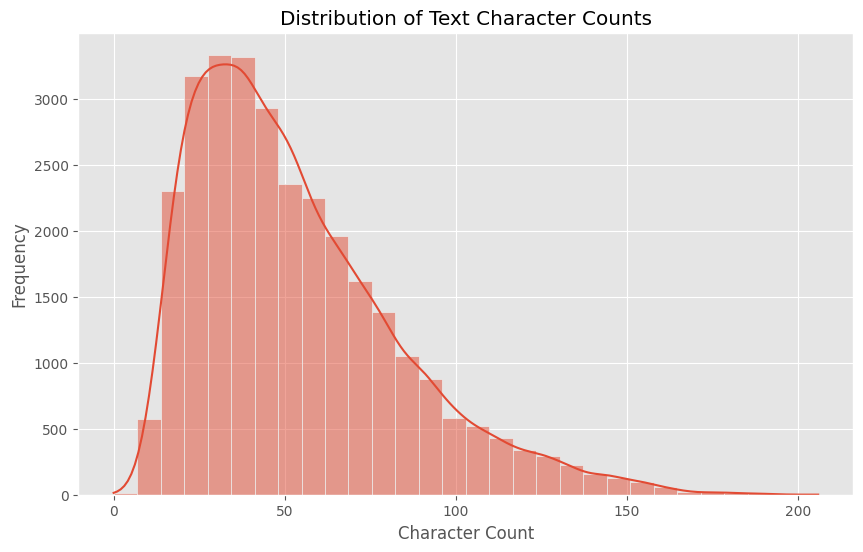

In [18]:
plt.figure(figsize = (10, 6)) 
sns.histplot( df['char_count'], bins = 30, kde = True ) 
plt.title('Distribution of Text Character Counts') 
plt.xlabel('Character Count') 
plt.ylabel('Frequency') 
plt.show()

- The graph represents the distribution of character counts in the text data. X-axis shows the number of characters per text, while the y-axis shows the frequency or number of texts that have a paticular character count. 

- The red line represents the Kernel Density Estimation (KDE), which shows the estimated probability density of the character count distribution. From the graph, most of the texts in the dataset have around 25 to 50 characters, with a peak of around 35 characters. As the character count increseases beyond 50, the frequency of texts with higher character counts gradually decreases.

Graph distribution of text word counts.

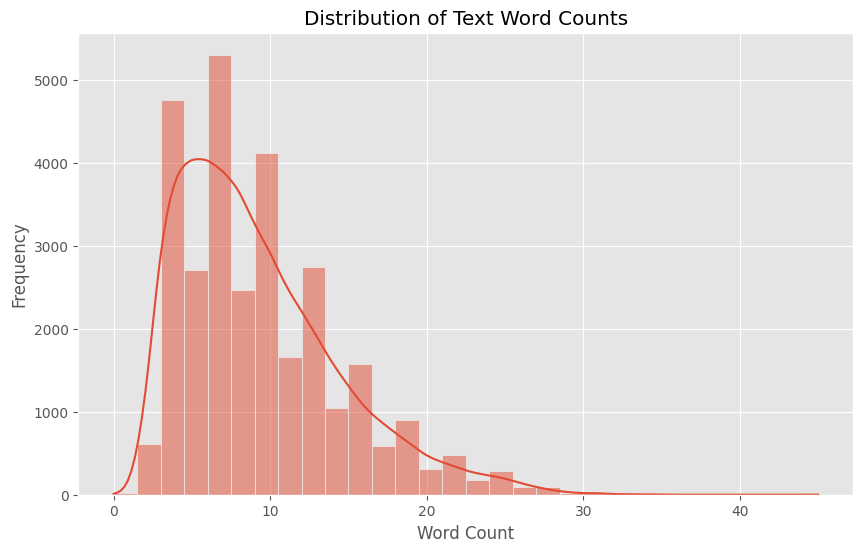

In [19]:
plt.figure(figsize = (10, 6)) 
sns.histplot( df['word_count'], bins = 30, kde = True ) 
plt.title('Distribution of Text Word Counts') 
plt.xlabel('Word Count') 
plt.ylabel('Frequency') 
plt.show()

- The graph represents the distribution of word counts in the text data. X-axis shows the number of words per text, while the y-axis shows the frequency or number of texts that have a paticular word count. 

- The red line represents the Kernel Density Estimation (KDE), which shows the estimated probability density of the word count distribution. From the graph, it can be observed that most text contains around 5 to 10 words, with a peak at about 6 words. As word counts increases beyond 10, the frequency of texts with higher word counts decreases steadily. This suggests that most texts in the dataset are relatively short, with very few texts containing more than 20 words.

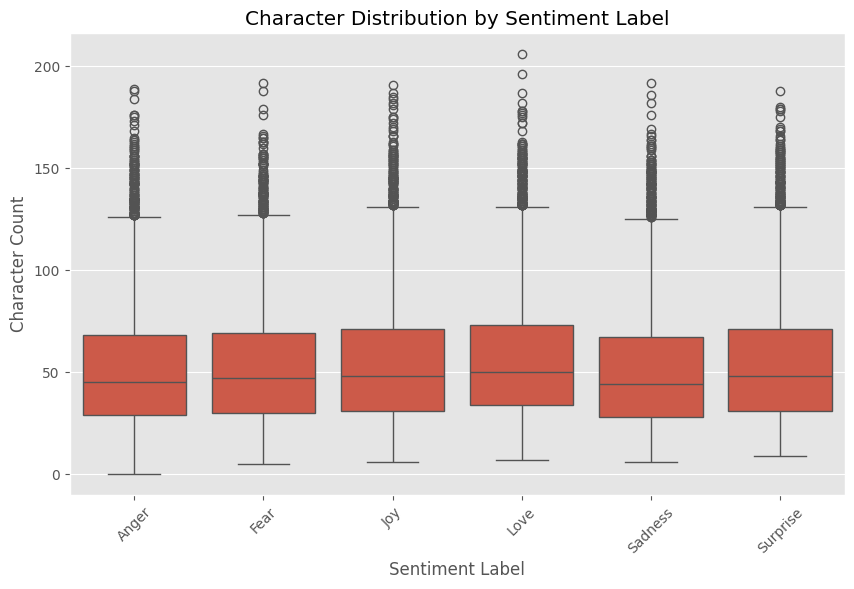

In [20]:
plt.figure(figsize = (10, 6)) 
sns.boxplot(x = 'label', y = 'char_count', data = df) 
plt.title('Character Distribution by Sentiment Label') 
plt.xlabel('Sentiment Label') 
plt.ylabel('Character Count') 
plt.xticks(rotation = 45) 
plt.show()

- The box plot visualizes the character distribution of texts across different sentiment labels: Fear, Joy, Love, Surprise, Anger, and Sadness. The y-axis represents number of characters in each text, while the x-axis shows the different sentiment labels.

- **Box and Whiskers:**
    - The box represents the interquartile range (IQR), which contains the middle 50% of the data. The bottom of the box shows the first quartile (25th percentile), the top shows the third quartile (75th percentile), and the line in the middle of the box is the median (50th percentile). 

    - The whiskers extending from the box represents the range of the data within 1.5 times the IQR from the first and third quartiles.

- **Circles (Outliers):** 
    - The circles above the whiskers represent the outliers--data points that fall outside 1.5 times the IQR. These are texts with unusually high character coutns compared to the majority of texts within the specific sentiment label. For example, Fear and Anger labels show some texts that have significantly higher character counts than others, which results in them being marked as outliers.

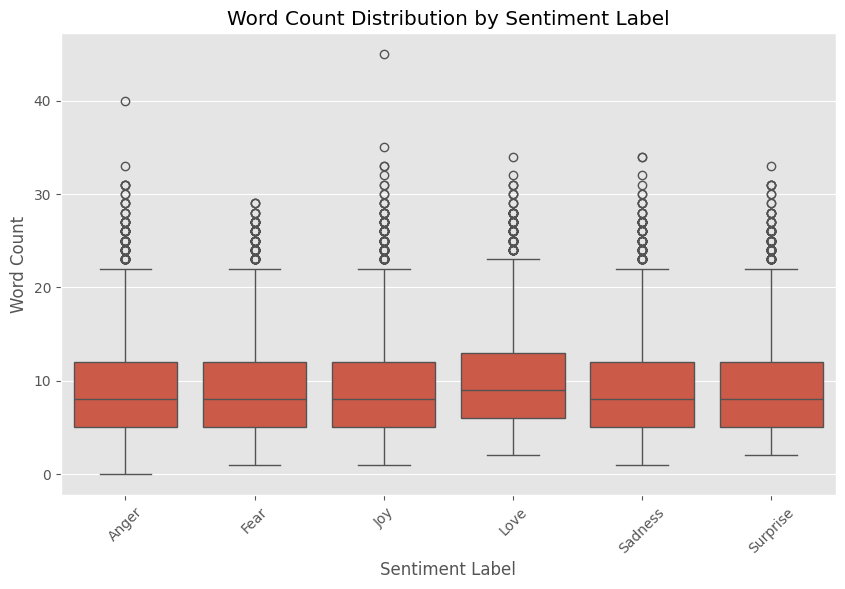

In [21]:
plt.figure(figsize = (10, 6)) 
sns.boxplot(x = 'label', y = 'word_count', data = df) 
plt.title('Word Count Distribution by Sentiment Label') 
plt.xlabel('Sentiment Label') 
plt.ylabel('Word Count') 
plt.xticks(rotation = 45) 
plt.show()

- The box plot visualizes the word count distribution of texts across different sentiment labels: Fear, Joy, Love, Surprise, Anger, and Sadness. The y-axis represents word count in each text, while the x-axis shows the different sentiment labels.

- **Box and Whiskers:**
    - The box represents the interquartile range (IQR), which contains the middle 50% of the data. The bottom of the box shows the first quartile (25th percentile), the top shows the third quartile (75th percentile), and the line in the middle of the box is the median (50th percentile). 

    - The whiskers extending from the box represents the range of the data within 1.5 times the IQR from the first and third quartiles.

- **Circles (Outliers):** 
    - The circles above the whiskers represent the outliers--data points that fall outside 1.5 times the IQR. These are texts with unusually high character coutns compared to the majority of texts within the specific sentiment label. For example, Fear and Anger labels show some texts that have significantly higher character counts than others, which results in them being marked as outliers.

# **NLTK**

- NLTK (Natural Language Tookit) is an essential tool for sentiment analysis systems for text data because it provides tools to process text by tokenizing, removing stop words, and steeming, which helps normalize language for analysis. Its extensive lexicon resources, like VADER, are tailored to detect sentiment in social media language, including handling nuances like sarcasm and emphasis. NLTK also allows for part-of-speech (POS) tagging, which helps capture word context, aiding in deeper understanding of sentiment in short, informal tweet structures. 

Converts the processed list of words back into a single string format for easier visualization and tokenization.

In [22]:
example = ' '.join(df['processed_text'].iloc[5] )
print(example)

heated argument lover whose intention marry near future rejected started cry stopped crying moment said


Tokenize sentence into individual words for further processing.

In [23]:
tokens = nltk.word_tokenize(example) 
tokens[:10]

['heated',
 'argument',
 'lover',
 'whose',
 'intention',
 'marry',
 'near',
 'future',
 'rejected',
 'started']

Tag each token with corresponding part of speech (POS).

In [24]:
tagged = nltk.pos_tag(tokens) 
tagged[:10]

[('heated', 'VBN'),
 ('argument', 'NN'),
 ('lover', 'NN'),
 ('whose', 'WP$'),
 ('intention', 'NN'),
 ('marry', 'NN'),
 ('near', 'IN'),
 ('future', 'JJ'),
 ('rejected', 'VBN'),
 ('started', 'VBD')]

Identifies and displays named entities (e.g., proper nouns, etc.) in the sentence.

In [25]:
entities = nltk.ne_chunk(tagged) 
entities.pprint()

(S
  heated/VBN
  argument/NN
  lover/NN
  whose/WP$
  intention/NN
  marry/NN
  near/IN
  future/JJ
  rejected/VBN
  started/VBD
  cry/NN
  stopped/VBD
  crying/VBG
  moment/NN
  said/VBD)


Define function that returns tokens and their POS tags for a list of words.

In [26]:
def process_tokens(tokens): 
    pos_tags = pos_tag(tokens) 
    return tokens, pos_tags

# Apply process_tokens function to each row in DataFrame, generating tokens and POS tags for each
df['tokens'], df['pos_tags'] = zip( *df['processed_text'].apply(process_tokens) ) 
print(df[['tokens', 'pos_tags']].head())

                                              tokens  \
0                           [feel, rebellious, like]   
1          [feel, completely, agitated, full, blame]   
2  [feel, like, witch, bc, aggravated, want, go, ...   
3  [feel, really, bitchy, really, iffy, read, jou...   
4              [feel, rude, move, past, immediately]   

                                            pos_tags  
0         [(feel, RB), (rebellious, JJ), (like, IN)]  
1  [(feel, VB), (completely, RB), (agitated, VBN)...  
2  [(feel, NN), (like, IN), (witch, NN), (bc, NN)...  
3  [(feel, NN), (really, RB), (bitchy, VBZ), (rea...  
4  [(feel, NN), (rude, JJ), (move, NN), (past, IN...  


# **VADER Sentiment Scoring**

- VADER (Valence Aware Dictionary and Sentiment Reasoner) model is a rule-based tool for sentiment analysis that's turned especially for social media contexts. It focuses on assessing the sentiment in text based on a lexicon and can capture emotions from not just words but also intensifiers, punctuations, and even emojis.

Import Sentiment Analyzer and Progress Bar Utility tools

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer   # Import VADER sentiment analysis tool from NLTK library
from tqdm.notebook import tqdm                          # Import tqdm's notebook-based progress bar utility to visualize iteration process

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()     # Create an instance of SentimentIntensityAnalyzer, which provides polarity score of a certain text

Example 1

In [28]:
sia.polarity_scores('I hate my life')

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

Example 2

In [29]:
sia.polarity_scores('I love you')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

Get polarity score of example text.

In [30]:
sia.polarity_scores(example)

{'neg': 0.521, 'neu': 0.337, 'pos': 0.142, 'compound': -0.8442}

Iterate through each row in the DataFrame 'df'.

In [31]:
# Empty dictionary to store VADER sentiment scores
res = {}

# Iterate through each row in the DataFrame with a progress bar
for i, row in tqdm( df.iterrows(), total = len(df) ): 
    text = row['text']  # Extract text from each row
    id = row['Index']   # Get row's index as 'id'
    res[id] = sia.polarity_scores(text) # Use VADER to analyze the sentiment and store each resulting sentiment in 'res'

  0%|          | 0/30000 [00:00<?, ?it/s]

Convert dictionary of results into a DataFrame, transpose it, and reset index.

In [32]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {
    'index': 'id',      # Rename 'index' to 'id' to match with original DataFrame
    'neg': 'vader_neg', # Rename columns to specify VADER sentiment scores
    'neu': 'vader_neu', 
    'pos': 'vader_pos'
}) 

# Merge 'vaders' DataFrame with original 'df' on the 'id' column
vaders = vaders.merge(df, how='left', left_on='id', right_on='Index')

Display final DataFrame.

In [33]:
vaders

,id,vader_neg,vader_neu,vader_pos,compound,Index,text,label,processed_text,char_count,word_count,message_length,tokens,pos_tags
0,411553,0.286,0.390,0.325,0.0772,411553,i feel rebellious and i like it,Anger,"[feel, rebellious, like]",18,3,Short,"[feel, rebellious, like]","[(feel, RB), (rebellious, JJ), (like, IN)]"
1,18079,0.532,0.468,0.000,-0.6901,18079,i feel completely agitated and full of blame,Anger,"[feel, completely, agitated, full, blame]",31,5,Short,"[feel, completely, agitated, full, blame]","[(feel, VB), (completely, RB), (agitated, VBN)..."
2,282107,0.186,0.504,0.310,0.3506,282107,i feel like a witch bc im aggravated and i wan...,Anger,"[feel, like, witch, bc, aggravated, want, go, ...",40,9,Short,"[feel, like, witch, bc, aggravated, want, go, ...","[(feel, NN), (like, IN), (witch, NN), (bc, NN)..."
3,49946,0.049,0.660,0.292,0.8861,49946,i feel really bitchy for doing this but im rea...,Anger,"[feel, really, bitchy, really, iffy, read, jou...",93,19,Long,"[feel, really, bitchy, really, iffy, read, jou...","[(feel, NN), (really, RB), (bitchy, VBZ), (rea..."
4,96367,0.250,0.750,0.000,-0.2500,96367,i feel rude but i move past it immediately,Anger,"[feel, rude, move, past, immediately]",27,5,Short,"[feel, rude, move, past, immediately]","[(feel, NN), (rude, JJ), (move, NN), (past, IN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,161528,0.171,0.676,0.153,-0.1154,161528,i told the kids about it but i would face the ...,Surprise,"[told, kids, would, face, fear, even, though, ...",50,11,Long,"[told, kids, would, face, fear, even, though, ...","[(told, JJ), (kids, NNS), (would, MD), (face, ..."
29996,408874,0.125,0.761,0.114,0.1779,408874,i have this strange expectation that other peo...,Surprise,"[strange, expectation, people, feel, strange, ...",83,12,Long,"[strange, expectation, people, feel, strange, ...","[(strange, JJ), (expectation, NN), (people, NN..."
29997,412778,0.078,0.559,0.363,0.7269,412778,i feel strange because i m not binary gendered...,Surprise,"[feel, strange, binary, gendered, still, feel,...",49,9,Short,"[feel, strange, binary, gendered, still, feel,...","[(feel, NN), (strange, JJ), (binary, NN), (gen..."
29998,75033,0.000,0.756,0.244,0.8516,75033,i feel as though whenever i start to become ov...,Surprise,"[feel, though, whenever, start, become, overwh...",128,21,Long,"[feel, though, whenever, start, become, overwh...","[(feel, VB), (though, IN), (whenever, JJ), (st..."


## **Plot VADER Results**

/var/folders/5d/lv8_nvzx4_z5kndxtdyr5fph0000gn/T/ipykernel_11330/709517055.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", fontsize = 12)


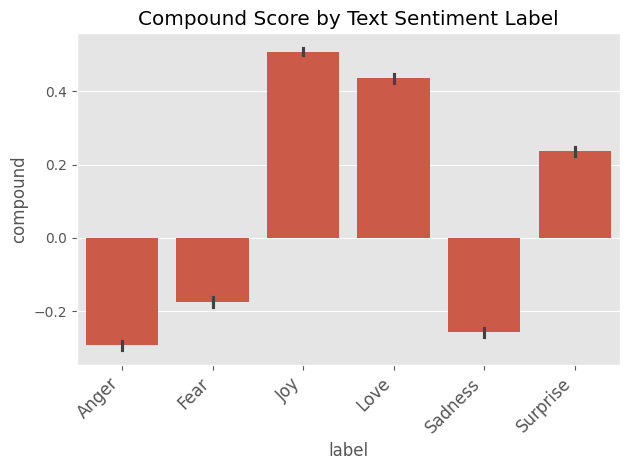

In [34]:
ax = sns.barplot(
    data = vaders, 
    x = 'label', 
    y = 'compound'
)
ax.set_title('Compound Score by Text Sentiment Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", fontsize = 12) 
plt.tight_layout() 
plt.show()

The bar plot visualizes the average compound sentiment score from the VADER sentiment analysis for each emotion label. Here's the analysis: 

   - **Joy and Love** exhibit the highest compound scores, indicating that these emotions are generally associated with positive sentiment in the text. 

   - **Surprise** shows a moderate positive compound score, which might reflect its mixed or neutral association, depending on the context. 
   
   - **Fear, Anger, and Sadness** have negative compound scores, aligning with their inherently negative connotations in sentiment analysis system.

This distribution aligns with typical sentiment expectations--positive emotions (like Joy and Love) yield positive scores, while negative emotions (like Fear and Sadness) yield negative scores, confirming that VADER effectively captures the polarity of these sentiments. 

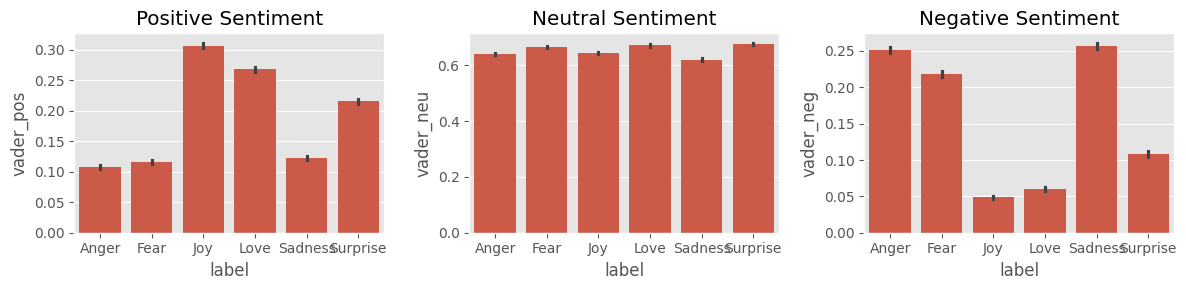

In [35]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3)) 
sns.barplot(data = vaders, x = 'label', y = 'vader_pos', ax = axs[0]) 
sns.barplot(data = vaders, x = 'label', y = 'vader_neu', ax = axs[1]) 
sns.barplot(data = vaders, x = 'label', y = 'vader_neg', ax = axs[2]) 
axs[0].set_title('Positive Sentiment') 
axs[1].set_title('Neutral Sentiment') 
axs[2].set_title('Negative Sentiment') 
plt.tight_layout()
plt.show() 

- The graphs represent the breakdown of positive, neutral, and negative sentiment scores for various emotional labels in the dataset. The "Positive Sentiment" graph shows that "Joy" has the highest positive score, followe by "Love" and "Surprise", suggesting these emotions are associated with positive language. The "Neutral Sentiment" graph is consistent across all labels, indicating a generally neutral tone in the text, while the "Negative Sentiment" graph highlights "Fear", "Anger", and "Sadness" with higher negative scores, showing these emotions are associated with negative expressions. 

# **RoBERTa Model**

- RoBERTa model introduces a powerful transformer-based approach for understanding nuanced language patterns in text data. RoBERTa (Robustly Optimized Bidirectional Encoder Representations from Transformers) model has been fine-tuned to capture complex contextual relationships within text, making it well-suited for identifying subtle sentiment differences. It leveregaes bidirectional attention, meaning it analyzes context both before and after each word, which helps interpret sarcasm, irony, and other complexities often present in text data. 

Import the necessary libraries.

In [36]:
from transformers import AutoTokenizer 
from transformers import AutoModelForSequenceClassification 

# Import softmax function for probability conversion
from scipy.special import softmax 

Specify RoBERTa model version pre-trained on Twitter sentiment data.

In [37]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load tokenizer for the RoBERTa model to convert text into tokens
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load sentiment analysis model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text) 
scores = output[0][0].detach().numpy() 
scores = softmax(scores) 
scores_dict = {
    'roberta_neg' : scores[0], 
    'roberta_neu' : scores[1], 
    'roberta_pos' : scores[2]
} 
print(scores_dict)

{'roberta_neg': np.float32(0.62513226), 'roberta_neu': np.float32(0.34692845), 'roberta_pos': np.float32(0.027939232)}


Declare function that calculates sentiment scores for a given text using the RoBERTa model. The function tokenizes, runs it through the model, applies the softmax function to get probabilities, and returns a dictionary with negative, neutral, and positive sentiment scores.

In [39]:
def polarity_scores_roberta(example): 
    # Tokenize input text for the RoBERTa model, outputting tensors in PyTorch format
    encoded_text = tokenizer(example, return_tensors='pt') 

    # Perform inference on the encoded text using the model
    output = model(**encoded_text) 

    # Extract model output and convert it to NumPy array for softmax processing
    scores = output[0][0].detach().numpy() 

    # Apply softmax function to obtain sentiment probabilities
    scores = softmax(scores)                     

    # Create dictionary with sentiment scores labeled as negative, neutral, and positive
    scores_dict = {
        'roberta_neg' : scores[0],  # Negative sentiment score
        'roberta_neu' : scores[1],  # Neutral sentiment score
        'roberta_pos' : scores[2]   # Positive sentiment score
    } 
    # Return dictionary containing sentiment scores
    return scores_dict

Loop iterates over each row in a DataFrame, processes the text with both VADER and RoBERTa sentiment analysis, renames the VADER keys for clarity, and combine the scores from both models.

In [40]:
res = {}

# Iterate over each row in DataFrame with progress tracking
for i, row in tqdm( df.iterrows(), total = len(df) ): 

    try: 
        # Retrieve the text and unique identifier from the DataFrame
        text = row['text'] 
        id = row['Index']
        # Get RoBERTa sentiment scores using custom function
        roberta_result = polarity_scores_roberta(text) 
        res[id] = roberta_result
    except RuntimeError: 
         #Print error message if there is an issue processing a row
        print(f'Broke for id {id}') 

  0%|          | 0/30000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Convert res dictionary into a DataFrame, renames columns for clarity, and merges it with the original DataFrame on the Index column or the DataFrame's index if Index is not available.

In [41]:
# Convert the 'res' dictionary to a DataFrame
results_df = pd.DataFrame(res).T  # Transpose so IDs align with rows

# Reset the index and rename the 'index' column to 'Id' for easier merging
results_df = results_df.reset_index().rename(columns={
    'index': 'Id',          # Rename index to Id
    'roberta_neg': 'roberta_neg',  # Keep RoBERTa score columns
    'roberta_neu': 'roberta_neu',
    'roberta_pos': 'roberta_pos'
})

# Merge results DataFrame with the original DataFrame on 'Id' and 'Index' columns
if 'Index' in df.columns:
    results_df = results_df.merge(df, how='left', left_on='Id', right_on='Index')
else:
    # If 'Index' is not a column, merge on index
    results_df = results_df.merge(df, how='left', left_on='Id', right_index=True)

Display first few rows of merged DataFrame.

In [42]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,Index,text,label,processed_text,char_count,word_count,message_length,tokens,pos_tags
0,411553,0.023713,0.181350,0.794937,411553,i feel rebellious and i like it,Anger,"[feel, rebellious, like]",18,3,Short,"[feel, rebellious, like]","[(feel, RB), (rebellious, JJ), (like, IN)]"
1,18079,0.920334,0.072259,0.007407,18079,i feel completely agitated and full of blame,Anger,"[feel, completely, agitated, full, blame]",31,5,Short,"[feel, completely, agitated, full, blame]","[(feel, VB), (completely, RB), (agitated, VBN)..."
2,282107,0.902631,0.089745,0.007624,282107,i feel like a witch bc im aggravated and i wan...,Anger,"[feel, like, witch, bc, aggravated, want, go, ...",40,9,Short,"[feel, like, witch, bc, aggravated, want, go, ...","[(feel, NN), (like, IN), (witch, NN), (bc, NN)..."
3,49946,0.764214,0.214226,0.021560,49946,i feel really bitchy for doing this but im rea...,Anger,"[feel, really, bitchy, really, iffy, read, jou...",93,19,Long,"[feel, really, bitchy, really, iffy, read, jou...","[(feel, NN), (really, RB), (bitchy, VBZ), (rea..."
4,96367,0.792875,0.194361,0.012764,96367,i feel rude but i move past it immediately,Anger,"[feel, rude, move, past, immediately]",27,5,Short,"[feel, rude, move, past, immediately]","[(feel, NN), (rude, JJ), (move, NN), (past, IN..."


In [ ]:
merged_df = vaders.merge(results_df, on='Index', how='inner')

# Rename columns if needed (e.g., _x, _y suffixes)
merged_df.rename(columns={
    'text_x': 'text',
    'label_x': 'label',
    'processed_text_x': 'processed_text',
    # Add renaming for other duplicated columns
}, inplace=True)

# Dynamically filter the columns to keep
columns_to_keep = [
    col for col in [
        'text', 'processed_text' ,'vader_neg', 'vader_neu', 'vader_pos', 'compound',
        'roberta_neg', 'roberta_neu', 'roberta_pos',
        'label',
        'char_count', 'word_count', 'message_length',
        'tokens', 'pos_tags'
    ] if col in merged_df.columns
]

merged_df = merged_df[columns_to_keep]
merged_df.head()

,text,processed_text,vader_neg,vader_neu,vader_pos,label
0,i feel rebellious and i like it,"[feel, rebellious, like]",0.286,0.390,0.325,Anger
1,i feel completely agitated and full of blame,"[feel, completely, agitated, full, blame]",0.532,0.468,0.000,Anger
2,i feel like a witch bc im aggravated and i wan...,"[feel, like, witch, bc, aggravated, want, go, ...",0.186,0.504,0.310,Anger
3,i feel really bitchy for doing this but im rea...,"[feel, really, bitchy, really, iffy, read, jou...",0.049,0.660,0.292,Anger
4,i feel rude but i move past it immediately,"[feel, rude, move, past, immediately]",0.250,0.750,0.000,Anger


Display each column currently in the DataFrame.

In [43]:
merged_df.columns

NameError: name 'merged_df' is not defined

# Examples

In [ ]:
results_df.query('label == "Joy"').sort_values('roberta_pos', ascending=False)['text'].values[0]
merged_df.query('label == "Joy"').sort_values('roberta_pos', ascending=False)['text'].values[0]

In [ ]:
results_df.query('label == "Joy"').sort_values('vader_pos', ascending=False)['text'].values[0]
merged_df.query('label == "Joy"').sort_values('vader_pos', ascending=False)['text'].values[0]

In [ ]:
results_df.query('label == "Joy"').sort_values('roberta_neg', ascending=False)['text'].values[0]
merged_df.query('label == "Joy"').sort_values('roberta_neg', ascending=False)['text'].values[0]

In [ ]:
results_df.query('label == "Joy"').sort_values('vader_neg', ascending=False)['text'].values[0]
merged_df.query('label == "Joy"').sort_values('vader_neg', ascending=False)['text'].values[0]

# **Neural Network**

In [44]:
import joblib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report


tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'].apply(lambda x: ' '.join(x)))


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])


X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# Build the neural network model 
model = Sequential()


model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(label_encoder.classes_), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',  
              optimizer=Adam(), 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_test, y_test))

model.save('emotion_model.h5')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Example: Predict emotion for a new sentence
new_sentence = "I am so happy today"
preprocessed_sentence = ' '.join(preprocess_text(new_sentence))  # Assuming you have a preprocessing function
new_vector = tfidf_vectorizer.transform([preprocessed_sentence]).toarray()

# Predict the emotion for the new sentence
predicted_label = model.predict(new_vector)
predicted_class = np.argmax(predicted_label, axis=1)
predicted_emotion = label_encoder.inverse_transform(predicted_class)

print(f"The emotion for the sentence '{new_sentence}' is: {predicted_emotion[0]}")

Epoch 1/40


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4485 - loss: 1.4759 - val_accuracy: 0.8707 - val_loss: 0.3706
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8761 - loss: 0.3684 - val_accuracy: 0.8762 - val_loss: 0.3519
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.2962 - val_accuracy: 0.8775 - val_loss: 0.3481
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9112 - loss: 0.2577 - val_accuracy: 0.8752 - val_loss: 0.3610
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9207 - loss: 0.2229 - val_accuracy: 0.8695 - val_loss: 0.3633
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9323 - loss: 0.1948 - val_accuracy: 0.8703 - val_loss: 0.3842
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9381 - loss: 0.1742 - val_accuracy: 0.8708 - val_loss: 0.3954
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9462 - loss: 0.1509 - val_accuracy: 0.8675 - val_

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
Accuracy: 0.86
              precision    recall  f1-score   support

       Anger       0.88      0.88      0.88       978
        Fear       0.85      0.81      0.83      1024
         Joy       0.82      0.83      0.83      1046
        Love       0.89      0.92      0.90       950
     Sadness       0.86      0.84      0.85      1033
    Surprise       0.88      0.91      0.90       969

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The emotion for the sentence 'I am so happy today' is: Joy


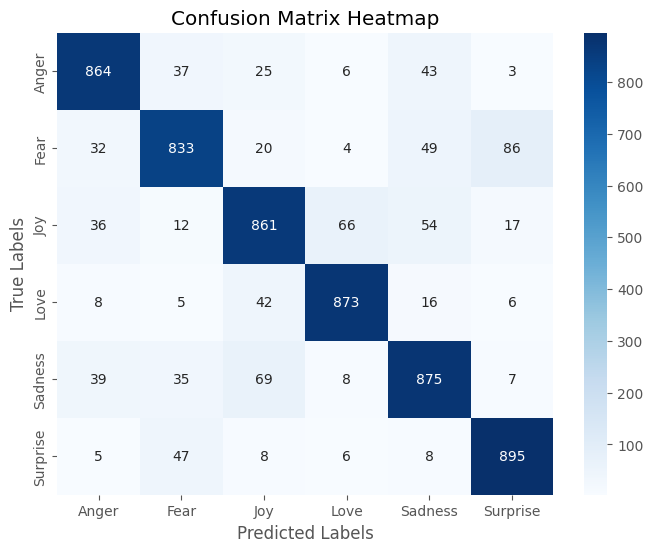

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test (true labels) and y_pred (predicted labels from model) are already defined
# If y_pred contains probabilities, use np.argmax to get the predicted class
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels if needed

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

new_sentence = "I am so happy today"
preprocessed_sentence = ' '.join(preprocess_text(new_sentence))  # Assuming you have a preprocessing function
new_vector = tfidf_vectorizer.transform([preprocessed_sentence]).toarray()

# Predict the emotion for the new sentence
predicted_label = model.predict(new_vector)
predicted_class = np.argmax(predicted_label, axis=1)
predicted_emotion = label_encoder.inverse_transform(predicted_class)

print(f"The emotion for the sentence '{new_sentence}' is: {predicted_emotion[0]}")

              precision    recall  f1-score   support

       Anger       0.88      0.88      0.88       978
        Fear       0.86      0.81      0.84      1024
         Joy       0.84      0.82      0.83      1046
        Love       0.91      0.92      0.91       950
     Sadness       0.84      0.85      0.84      1033
    Surprise       0.88      0.92      0.90       969

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000

Accuracy: 0.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
The emotion for the sentence 'I am so happy today' is: Joy


# **Decision Trees**

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(report)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

       Anger       0.87      0.87      0.87       978
        Fear       0.82      0.80      0.81      1024
         Joy       0.76      0.76      0.76      1046
        Love       0.87      0.91      0.89       950
     Sadness       0.84      0.80      0.82      1033
    Surprise       0.86      0.90      0.88       969

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000

Accuracy: 0.84


In [47]:

print(f"y_pred type: {type(y_pred)}, shape: {y_pred.shape}")
print(f"y_test type: {type(y_test)}, shape: {y_test.shape}")


if y_pred.ndim == 2:  
    y_pred = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))  
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Decision Trees')

plt.show()

y_pred type: <class 'numpy.ndarray'>, shape: (6000,)
y_test type: <class 'numpy.ndarray'>, shape: (6000,)


NameError: name 'confusion_matrix' is not defined